In [1]:
BATCH_SIZE = 1024

PAD_SIZE = 80
TARGET_LABELS = [
    "Solved",
    "Improvement",
    #"AreaRatio",
    #"Stacks"
]

SEED = 3093453

# Preprocessing

## Load Packages and Data

In [2]:
import os
import sys

import numpy as np
import pandas as pd
import polars as pl

import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

# Random Seeds
np.random.seed(SEED)
tf.random.set_seed(SEED)



# Cosmetics
np.set_printoptions(
    edgeitems=30,
    linewidth=100_000,
    suppress=True
    )

sns.set(
    context="talk",
    style="darkgrid"
)


cwd = os.getcwd()
cwd, _ = os.path.split(cwd)

In [3]:
import tensorflow as tf
from tensorflow import keras

train_samples = os.path.join(cwd, "data", "train", "2D", "MIP")
val_samples = os.path.join(cwd, "data", "validation", "2D", "MIP")

train_dataset = keras.preprocessing.text_dataset_from_directory(
    directory = train_samples,
    labels = None,
    batch_size = BATCH_SIZE,
    max_length = None,
    shuffle = True,
    seed = SEED,
    validation_split = 0.1,
    subset = "training",
    follow_links = False
)

val_dataset = keras.preprocessing.text_dataset_from_directory(
    directory = train_samples,
    labels = None,
    batch_size = BATCH_SIZE,
    max_length = None,
    shuffle = True,
    seed = SEED,
    validation_split = 0.1,
    subset = "validation",
    follow_links = False
)



Found 489623 files belonging to 1 classes.
Using 440661 files for training.


2023-12-28 22:14:43.330338: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-28 22:14:43.330372: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-28 22:14:43.330378: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-28 22:14:43.330610: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-28 22:14:43.330949: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 489623 files belonging to 1 classes.
Using 48962 files for validation.


In [4]:
for X in train_dataset.take(1):
    pass

df = pl.DataFrame({"raw": X.numpy().astype(str)})
print(df[0, 0])

dataset: B
instance: MA2
+-----------+
2D Packing MIP with Time Limit 15 [s] in Truck P355037001
Stack 0 with items: ['0090016200_26102022000265', '0090016200_26102022000255']
Stack 1 with items: ['0090016200_26102022012372', '0090016200_26102022012372', '0090016200_26102022017816']
Stack 2 with items: ['0090016200_26102022006635', '0090016200_26102022002470', '0090016200_26102022013378']
Stack 3 with items: ['0090016200_26102022015271', '0090016200_26102022007589', '0090016200_26102022015271']
Stack 4 with items: ['0090016200_26102022001327', '0090016200_26102022001327']
Stack 5 with items: ['0090016200_26102022015678', '0090016200_26102022004493', '0090016200_26102022015678']
Stack 6 with items: ['0090016200_26102022019753', '0090016200_26102022019604', '0090016200_26102022019753']
Stack 7 with items: ['0090016200_26102022016002', '0090016200_26102022016002', '0090016200_26102022016002']
Stack 8 with items: ['0090016200_26102022012624', '0090016200_26102022012624', '0090016200_261020

## Loading CSVs

In [5]:
folder = "truck-item-infos"
file = "items.csv"

item_path = os.path.join(cwd, folder, file)
items = pl.read_csv(source = item_path);

items = items.lazy().with_columns([
    (pl.col("Item ident").alias("item_id")),
    (pl.col("Length") / 1000), # mm to m
    (pl.col("Width") / 1000),  # mm to m
    (pl.col("Height") / 1000), # mm to m
    (pl.col("Nesting height") / 1000), # mm to m
    (pl.col("Weight") / 1000), # kg to tons
    (pl.col("Forced orientation") == "lengthwise").alias("ForcedLength"),
    (pl.col("Forced orientation") == "widthwise").alias("ForcedWidth"),
    ((pl.col("Height") - pl.col("Nesting height")) / 1000).alias("NestedHeight"),
    pl.col("dataset").str.extract("([A-Z])")
]).drop([
    "Forced orientation", "Max stackability", "Inventory cost",
    "Earliest arrival time", "Latest arrival time", "Number of items",
    "instance_id",
    "Stackability code",
    "Item ident", # drop because of rename earlier
    # Unnecassary columns
    "Product code",
    "Package",
    "Plant code",
    "Product code",
    "Package code",
    "NestedHeight"
]).unique()

items.collect()

shape: (3_680_457, 13)
┌────────────┬────────────┬────────────┬────────┬───┬──────────┬───────────┬───────────┬───────────┐
│ Supplier   ┆ Supplier   ┆ Plant dock ┆ Length ┆ … ┆ instance ┆ item_id   ┆ ForcedLen ┆ ForcedWid │
│ code       ┆ dock       ┆ ---        ┆ ---    ┆   ┆ ---      ┆ ---       ┆ gth       ┆ th        │
│ ---        ┆ ---        ┆ str        ┆ f64    ┆   ┆ str      ┆ str       ┆ ---       ┆ ---       │
│ i64        ┆ str        ┆            ┆        ┆   ┆          ┆           ┆ bool      ┆ bool      │
╞════════════╪════════════╪════════════╪════════╪═══╪══════════╪═══════════╪═══════════╪═══════════╡
│ 90016100   ┆ K11        ┆ GRD1       ┆ 2.3    ┆ … ┆ BY       ┆ 009001690 ┆ false     ┆ false     │
│            ┆            ┆            ┆        ┆   ┆          ┆ 0_2702202 ┆           ┆           │
│            ┆            ┆            ┆        ┆   ┆          ┆ 3000013   ┆           ┆           │
│ 2573225    ┆ null       ┆ GRF1       ┆ 1.9    ┆ … ┆ BY       ┆ 009001690 ┆ false     ┆ false     │
│            ┆            ┆            ┆        ┆   ┆          ┆ 0_2702202 ┆           ┆           │
│            ┆            ┆            ┆        ┆   ┆          ┆ 3000038   ┆           ┆           │
│ 11740101   ┆ null       ┆ 169GD-60   ┆ 1.2    ┆ … ┆ BY       ┆ 009001690 ┆ false     ┆ false     │
│            ┆            ┆            ┆        ┆   ┆          ┆ 0_2702202 ┆           ┆           │
│            ┆            ┆            ┆        ┆   ┆          ┆ 3000048   ┆           ┆           │
│ 679301     ┆ null       ┆ 169GB-20   ┆ 1.8    ┆ … ┆ BY       ┆ 009001690 ┆ false     ┆ false     │
│            ┆            ┆            ┆        ┆   ┆          ┆ 0_2702202 ┆           ┆           │
│            ┆            ┆            ┆        ┆   ┆          ┆ 3000067   ┆           ┆           │
│ …          ┆ …          ┆ …          ┆ …      ┆ … ┆ …        ┆ …         ┆ …         ┆ …         │
│ 40695600   ┆ null       ┆ 383G4B     ┆ 1.2    ┆ … ┆ TA6      ┆ 009003830 ┆ false     ┆ false     │
│            ┆            ┆            ┆        ┆   ┆          ┆ 0_1406202 ┆           ┆           │
│            ┆            ┆            ┆        ┆   ┆          ┆ 3011773   ┆           ┆           │
│ 40695600   ┆ null       ┆ 383G4B     ┆ 1.6    ┆ … ┆ TA6      ┆ 009003830 ┆ false     ┆ false     │
│            ┆            ┆            ┆        ┆   ┆          ┆ 0_1406202 ┆           ┆           │
│            ┆            ┆            ┆        ┆   ┆          ┆ 3011845   ┆           ┆           │
│ 40695600   ┆ null       ┆ 383G4B     ┆ 1.2    ┆ … ┆ TA6      ┆ 009003830 ┆ false     ┆ false     │
│            ┆            ┆            ┆        ┆   ┆          ┆ 0_1406202 ┆           ┆           │
│            ┆            ┆            ┆        ┆   ┆          ┆ 3011940   ┆           ┆           │
│ 40695600   ┆ null       ┆ 383G4B     ┆ 1.2    ┆ … ┆ TA6      ┆ 009003830 ┆ false     ┆ false     │
│            ┆            ┆            ┆        ┆   ┆          ┆ 0_1406202 ┆           ┆           │
│            ┆            ┆            ┆        ┆   ┆          ┆ 3011962   ┆           ┆           │
└────────────┴────────────┴────────────┴────────┴───┴──────────┴───────────┴───────────┴───────────┘

In [6]:
file = "trucks.csv"

truck_path = os.path.join(cwd, folder, file)

truck_clms = ["Id truck", "dataset", "instance",
              "Supplier code", "Supplier dock", "Plant dock",
              "Supplier loading order", "Supplier dock loading order", "Plant dock loading order",
             ]

truck_stops = (
    pl.read_csv(source = truck_path, columns = truck_clms)
    .lazy()
    .rename({"Id truck": "truck_id"})
    .sort(["dataset", "instance", "truck_id"])
    .with_columns([pl.col("dataset").str.extract("(\w)")])
    .unique()
)
truck_stops.collect()

shape: (897_317, 9)
┌────────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬─────────┬──────────┐
│ Supplier   ┆ Supplier   ┆ Supplier  ┆ Supplier  ┆ … ┆ Plant     ┆ truck_id  ┆ dataset ┆ instance │
│ code       ┆ loading    ┆ dock      ┆ dock      ┆   ┆ dock      ┆ ---       ┆ ---     ┆ ---      │
│ ---        ┆ order      ┆ ---       ┆ loading   ┆   ┆ loading   ┆ str       ┆ str     ┆ str      │
│ i64        ┆ ---        ┆ str       ┆ order     ┆   ┆ order     ┆           ┆         ┆          │
│            ┆ i64        ┆           ┆ ---       ┆   ┆ ---       ┆           ┆         ┆          │
│            ┆            ┆           ┆ i64       ┆   ┆ i64       ┆           ┆         ┆          │
╞════════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═════════╪══════════╡
│ 29908700   ┆ 1          ┆ null      ┆ 1         ┆ … ┆ 1         ┆ P18773040 ┆ A       ┆ AS       │
│            ┆            ┆           ┆           ┆   ┆           ┆ 7         ┆         ┆          │
│ 29908700   ┆ 1          ┆ null      ┆ 1         ┆ … ┆ 1         ┆ P18873040 ┆ A       ┆ AS       │
│            ┆            ┆           ┆           ┆   ┆           ┆ 5         ┆         ┆          │
│ 29908700   ┆ 1          ┆ null      ┆ 1         ┆ … ┆ 1         ┆ P18973040 ┆ A       ┆ AS       │
│            ┆            ┆           ┆           ┆   ┆           ┆ 3         ┆         ┆          │
│ 29908700   ┆ 1          ┆ null      ┆ 1         ┆ … ┆ 1         ┆ P18973040 ┆ A       ┆ AS       │
│            ┆            ┆           ┆           ┆   ┆           ┆ 7         ┆         ┆          │
│ …          ┆ …          ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …       ┆ …        │
│ 11565600   ┆ 3          ┆ null      ┆ 3         ┆ … ┆ 2         ┆ P24042310 ┆ X       ┆ TR7      │
│            ┆            ┆           ┆           ┆   ┆           ┆ 9         ┆         ┆          │
│ 27830201   ┆ 1          ┆ null      ┆ 1         ┆ … ┆ 4         ┆ P24042420 ┆ X       ┆ TR7      │
│            ┆            ┆           ┆           ┆   ┆           ┆ 1         ┆         ┆          │
│ 28132600   ┆ 1          ┆ null      ┆ 1         ┆ … ┆ 0         ┆ P24042530 ┆ X       ┆ TR7      │
│            ┆            ┆           ┆           ┆   ┆           ┆ 1         ┆         ┆          │
│ 11141500   ┆ 1          ┆ null      ┆ 1         ┆ … ┆ 2         ┆ P24042550 ┆ X       ┆ TR7      │
│            ┆            ┆           ┆           ┆   ┆           ┆ 1         ┆         ┆          │
└────────────┴────────────┴───────────┴───────────┴───┴───────────┴───────────┴─────────┴──────────┘

In [7]:
file = "trucks.csv"

truck_path = os.path.join(cwd, folder, file)

truck_clms = ["Id truck", "dataset", "instance",
              "Length", "Width", "Max weight",
              "EMmm", "EMmr"
             ]

truck_dims = (
    pl.read_csv(source = truck_path, columns = truck_clms)
    .lazy()
    .rename({"Id truck": "truck_id", "Max weight": "Weight"})
    .sort(["dataset", "instance", "truck_id"])
    .with_columns([pl.col("dataset").str.extract("(\w)")])
    .unique()
)

truck_dims = truck_dims.with_columns([
    (pl.col("Length") / 1000),
    (pl.col("Width") / 1000),
    (pl.col("Weight") / 1000),
    (pl.col("EMmm") / 1000),
    (pl.col("EMmr") / 1000),
])

truck_dims.collect()

shape: (518_012, 8)
┌────────────┬────────┬───────┬────────┬──────┬──────┬─────────┬──────────┐
│ truck_id   ┆ Length ┆ Width ┆ Weight ┆ EMmm ┆ EMmr ┆ dataset ┆ instance │
│ ---        ┆ ---    ┆ ---   ┆ ---    ┆ ---  ┆ ---  ┆ ---     ┆ ---      │
│ str        ┆ f64    ┆ f64   ┆ f64    ┆ f64  ┆ f64  ┆ str     ┆ str      │
╞════════════╪════════╪═══════╪════════╪══════╪══════╪═════════╪══════════╡
│ P188721401 ┆ 14.94  ┆ 2.5   ┆ 24.0   ┆ 12.0 ┆ 31.5 ┆ A       ┆ AS       │
│ P189730401 ┆ 14.94  ┆ 2.5   ┆ 24.0   ┆ 12.0 ┆ 31.5 ┆ A       ┆ AS       │
│ P192730405 ┆ 14.94  ┆ 2.5   ┆ 24.0   ┆ 12.0 ┆ 31.5 ┆ A       ┆ AS       │
│ P192730507 ┆ 14.94  ┆ 2.5   ┆ 24.0   ┆ 12.0 ┆ 31.5 ┆ A       ┆ AS       │
│ …          ┆ …      ┆ …     ┆ …      ┆ …    ┆ …    ┆ …       ┆ …        │
│ P240275101 ┆ 13.5   ┆ 2.44  ┆ 24.0   ┆ 11.5 ┆ 31.5 ┆ X       ┆ TR7      │
│ P240277001 ┆ 13.5   ┆ 2.44  ┆ 24.0   ┆ 11.5 ┆ 31.5 ┆ X       ┆ TR7      │
│ P240420403 ┆ 13.5   ┆ 2.44  ┆ 24.0   ┆ 12.0 ┆ 31.5 ┆ X       ┆ TR7      │
│ P240424201 ┆ 13.5   ┆ 2.44  ┆ 24.0   ┆ 12.0 ┆ 31.5 ┆ X       ┆ TR7      │
└────────────┴────────┴───────┴────────┴──────┴──────┴─────────┴──────────┘

## Preprocessing Functions:

In [8]:
import sys
sys.path.append("..")

from utils.preprocessing import input_output_generation

In [9]:
cx, cy = input_output_generation(
    X,
    #target_labels=TARGET_LABELS,
    pad_size=PAD_SIZE,
    shuffle=False,
    items=items,
    truck_stops=truck_stops,
    truck_dims=truck_dims,
)

In [10]:
cx[0][0, :40]

array([[ 1.2       ,  1.        ,  0.37984   ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.44000006],
       [ 1.2       ,  1.        ,  0.424516  ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.44000006],
       [ 1.2       ,  1.        ,  0.577192  ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.44000006],
       [ 1.2       ,  1.        ,  0.252146  ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.44000006],
       [ 1.2       ,  1.        ,  0.377846  ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.44000006],
       [ 1.206     ,  1.01      ,  0.2851    ,  0.        ,  0.        ,  1.        ,  0.        ,  0.02800012,  0.42000008],
       [ 1.206     ,  1.01      ,  0.3985    ,  0.        ,  0.        ,  1.        ,  0.        ,  0.02800012,  0.42000008],
       [ 1.206     ,  1.01      ,  0.07856   ,  0.        ,  0.        ,  1.        ,  0.        ,  0.02800012,  0.420

# DNN

### Optimizer, Losses and Metrics

In [11]:
# Learning Rate
initial_lr = 10e-3 # 10e-3
lr_decay = 0.9995

# Optimizer
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = initial_lr)

In [12]:
loss_solved = tf.keras.losses.BinaryFocalCrossentropy(
    gamma=2,
    alpha = cy[0].mean(),
    name='solved_focal_loss'
)

loss_improvement = tf.keras.losses.BinaryFocalCrossentropy(
    gamma=1.5,
    alpha = cy[1].mean(),
    name='improvement_focal_loss'
)

loss_area_ratio = tf.keras.losses.BinaryCrossentropy(
    name='area_ratio_crossentropy'
)



loss_stacks = tf.keras.losses.BinaryFocalCrossentropy(
    gamma=6,
    alpha = cy[-1].mean(),
    name='stacks_focal_loss'
)

for i, target in enumerate(TARGET_LABELS):
    print(f"{target} Prevalence: {cy[i].mean():.1%}")

Solved Prevalence: 37.9%
Improvement Prevalence: 46.6%


In [13]:
target_loss_objects = {
    "Solved": loss_solved,
    "Improvement": loss_improvement,
    "AreaRatio": loss_area_ratio,
    "Stacks": loss_stacks,
}

loss_objects = [target_loss_objects[target] for target in TARGET_LABELS]
mean_losses = [tf.keras.metrics.Mean(name=target) for target in TARGET_LABELS]

In [14]:
all_target_metrics: list[list[tf.keras.metrics]] = {
    "Solved": [
        tf.keras.metrics.Precision(name = "PRC"),
        tf.keras.metrics.Recall(name = "SNS"),
        tf.keras.metrics.AUC(curve='PR', name="AUC"),
        tf.keras.metrics.BinaryAccuracy(name = "ACC")
    ],
    "Improvement": [
        tf.keras.metrics.Precision(name = "PRC"),
        tf.keras.metrics.Recall(name = "SNS"),
        tf.keras.metrics.AUC(curve='PR', name="AUC"),
        tf.keras.metrics.BinaryAccuracy(name = "ACC")
    ],
    "AreaRatio": [
        keras.metrics.RootMeanSquaredError(name="RMSE"),
        keras.metrics.MeanAbsoluteError(name="MAE")
    ],
    "Stacks": [
        tf.keras.metrics.Precision(name = "PRC"),
        tf.keras.metrics.Recall(name = "SNS"),
        tf.keras.metrics.AUC(curve='PR', name="AUC"),
        tf.keras.metrics.BinaryAccuracy(name = "ACC")
    ],
}

all_metrics = [all_target_metrics[target] for target in TARGET_LABELS]

## Architecture

In [15]:
from tensorflow.keras.layers import Masking, BatchNormalization, MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.layers import Add, Dense, Input, Reshape, Permute, Lambda, Concatenate
from keras import backend as K
from tensorflow.keras import Model

from utils.DNN.model_layers import TransformerEncoder



N_FEATURES = cx[0].shape[-1]

def build_model(
    target_labels: list[str]=["Improvement"],
    n_features: int=9,
    n_blocks: int=3,
    num_heads: int=3,
    use_bias: bool=True,
    upscale_factor: float=1,
    use_PreLN: bool=True,
    split_last_layer: bool=False,
    encoder_dropout: float=0.1,
    activation: str="gelu", # "relu" "gelu" "selu" "swish"
    bias_regularizer=None,
    pad_size: int=80
) -> Model:
    """
    
    """

    # Input
    input_stack_level = Input(shape=(pad_size, n_features), name="StackLevelInputFeatures", dtype=tf.float16,)
    input_time_limit = Input(shape=(1), name="TimeLimitInput", dtype=tf.float16,)
    inputs = [input_stack_level, input_time_limit]
    
    # Masking padded input
    masking_layer = Masking(
        mask_value=0,
        input_shape=(pad_size, n_features),
        dtype=tf.float16,
        name="MaskingLayer"
    )
    x = masking_layer(input_stack_level)

    #batch_norm_layer = BatchNormalization(name="BatchNormalizationLayer")
    #x = batch_norm_layer(masking_layer)
    
    key_dim = int(n_features/num_heads)
    # Encoder Block
    for i in range(1, n_blocks+1):
        # Self attention with add and layer norm
        self_attention_layer = TransformerEncoder(
            num_heads=num_heads,
            key_dim=int(N_FEATURES/num_heads),
            activation=activation,
            units = N_FEATURES,
            upscale_factor=upscale_factor,
            dropout=encoder_dropout,
            use_bias=use_bias,
            use_PreLN=use_PreLN,
            bias_regularizer=bias_regularizer,
            idx = i,
        )
        x, _ = self_attention_layer(x)
    
    final_layer_norm = LayerNormalization(name="FinalLayerNorm")
    x = final_layer_norm(x)

    if split_last_layer:
        self_attention_layer_solved = TransformerEncoder(
            num_heads=num_heads, key_dim=key_dim,
            activation=activation,
            units = N_FEATURES,
            upscale_factor=upscale_factor,
            dropout=encoder_dropout,
            use_bias=use_bias,
            use_PreLN=use_PreLN,
            bias_regularizer=bias_regularizer,
            idx="Solved"
        )
        attention_solved, _ = self_attention_layer_solved(x)
        attention_solved = final_layer_norm(attention_solved)
        
        self_attention_layer_improvement = TransformerEncoder(
            num_heads=num_heads, key_dim=key_dim,
            activation=activation,
            units = N_FEATURES,
            upscale_factor=upscale_factor,
            dropout=encoder_dropout,
            use_bias=use_bias,
            use_PreLN=use_PreLN,
            bias_regularizer=bias_regularizer,
            idx="Improvement",
        )
        attention_improvement, _ = self_attention_layer_improvement(x)
        attention_improvement = final_layer_norm(attention_improvement)

        self_attention_layer_area_ratio = TransformerEncoder(
            num_heads=num_heads, key_dim=key_dim,
            activation=activation,
            units = N_FEATURES,
            upscale_factor=upscale_factor,
            dropout=encoder_dropout,
            use_bias=use_bias,
            use_PreLN=use_PreLN,
            bias_regularizer=bias_regularizer,
            idx="AreaRatio",
        )
        
        attention_area_ratio, _ = self_attention_layer_area_ratio(x)
        attention_area_ratio = final_layer_norm(attention_area_ratio)




    
    
    # After Attention, reduce to single dimension
    add_across_dim = Lambda(
        lambda x: K.sum(x, axis=1)/PAD_SIZE**1,
        output_shape=lambda s: (s[0], s[2]),
        name = "ReduceStackDimensionViaSummation"
    )
    
    reshape = Lambda(lambda x: tf.squeeze(x), name="Output")
    
    # Pipe Attention directly into missing stack prediction:
    
    output_stacks = Dense(1, activation='sigmoid', name = "PredictionStacks")
    xx = output_stacks(x)
    output_stacks = reshape(xx)
    
    
    
    # Standardize the Time Limit
    # - The time limit ranges from 0 to 30,
    # - (tl - 15)/5 should roughly normalize
    
    normalize_time_limit = Lambda(
        lambda x: (x-15)/5,
        name = "StandardizeTimeLimit"
    )
    input_time_limit = normalize_time_limit(input_time_limit)
    concatenate_layer = Concatenate(axis=-1, name=f"ConcatenateLayer")
    #x = concatenate_layer([x, input_time_limit])
    
    
    
    
    
    if split_last_layer:
        attention_solved = add_across_dim(attention_solved)
        attention_improvement = add_across_dim(attention_improvement)
        attention_area_ratio = add_across_dim(attention_area_ratio)
    else:
        x = add_across_dim(x)

    if split_last_layer:
        xx = concatenate_layer([attention_solved, input_time_limit])
    else:
        xx = concatenate_layer([x, input_time_limit])
    fully_connected_layer_solved = Dense(units=n_features+1, activation=activation,name=f"FullyConnectedLayerSolved")
    xx = fully_connected_layer_solved(xx)
    output_solved = Dense(1, activation='sigmoid', name = "PredictionSolved")
    xx = output_solved(xx)
    output_solved = reshape(xx)



    if split_last_layer:
        xx = concatenate_layer([attention_improvement, input_time_limit])
    else:
        xx = concatenate_layer([x, input_time_limit])
    fully_connected_layer_improvement = Dense(units=n_features+1, activation=activation,name=f"FullyConnectedLayerImprovement")
    xx = fully_connected_layer_improvement(xx)
    output_improvement = Dense(1, activation='sigmoid', name = "PredictionImprovement")
    xx = output_improvement(xx)
    output_improvement = reshape(xx)

    if split_last_layer:
        xx = concatenate_layer([attention_area_ratio, input_time_limit])
    else:
        xx = concatenate_layer([x, input_time_limit])
    fully_connected_layer_area_ratio = Dense(units=n_features+1, activation=activation,name=f"FullyConnectedLayerAreaRatio")
    xx = fully_connected_layer_area_ratio(xx)
    output_area_ratio = Dense(1, activation='sigmoid', name = "PredictionAreaRatio")
    xx = output_area_ratio(xx)
    output_area_ratio = reshape(xx)
    
    
    
    
    target_outputs = {
        "Solved": output_solved,
        "Improvement": output_improvement,
        "AreaRatio": output_area_ratio,
        "Stacks": output_stacks
    }
    
    outputs = [target_outputs[target] for target in target_labels]
    
    model = Model(
        inputs=inputs,
        outputs=outputs,
    )
    
    return model

## Model Parameters

In [16]:
N_FEATURES = cx[0].shape[-1]

num_heads=3

model = build_model(
    target_labels=TARGET_LABELS,
    n_features=N_FEATURES,
    pad_size=PAD_SIZE,
    # Hyperparameters
    n_blocks=5,
    num_heads=num_heads,
    use_bias=True,
    upscale_factor=1,
    use_PreLN=True,
    split_last_layer=False,
    encoder_dropout=0.1,
    activation="gelu", # "relu" "gelu" "selu" "swish"
    bias_regularizer=None,
)

model

### Model Architecture Inspection:

In [17]:
_ = model(cx) # just check if it works
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 StackLevelInputFeatures (I  [(None, 80, 9)]              0         []                            
 nputLayer)                                                                                       
                                                                                                  
 MaskingLayer (Masking)      (None, 80, 9)                0         ['StackLevelInputFeatures[0][0
                                                                    ]']                           
                                                                                                  
 transformer_encoder (Trans  ((None, 80, 9),              576       ['MaskingLayer[0][0]']        
 formerEncoder)               (None, 3, 80, 80))                                              

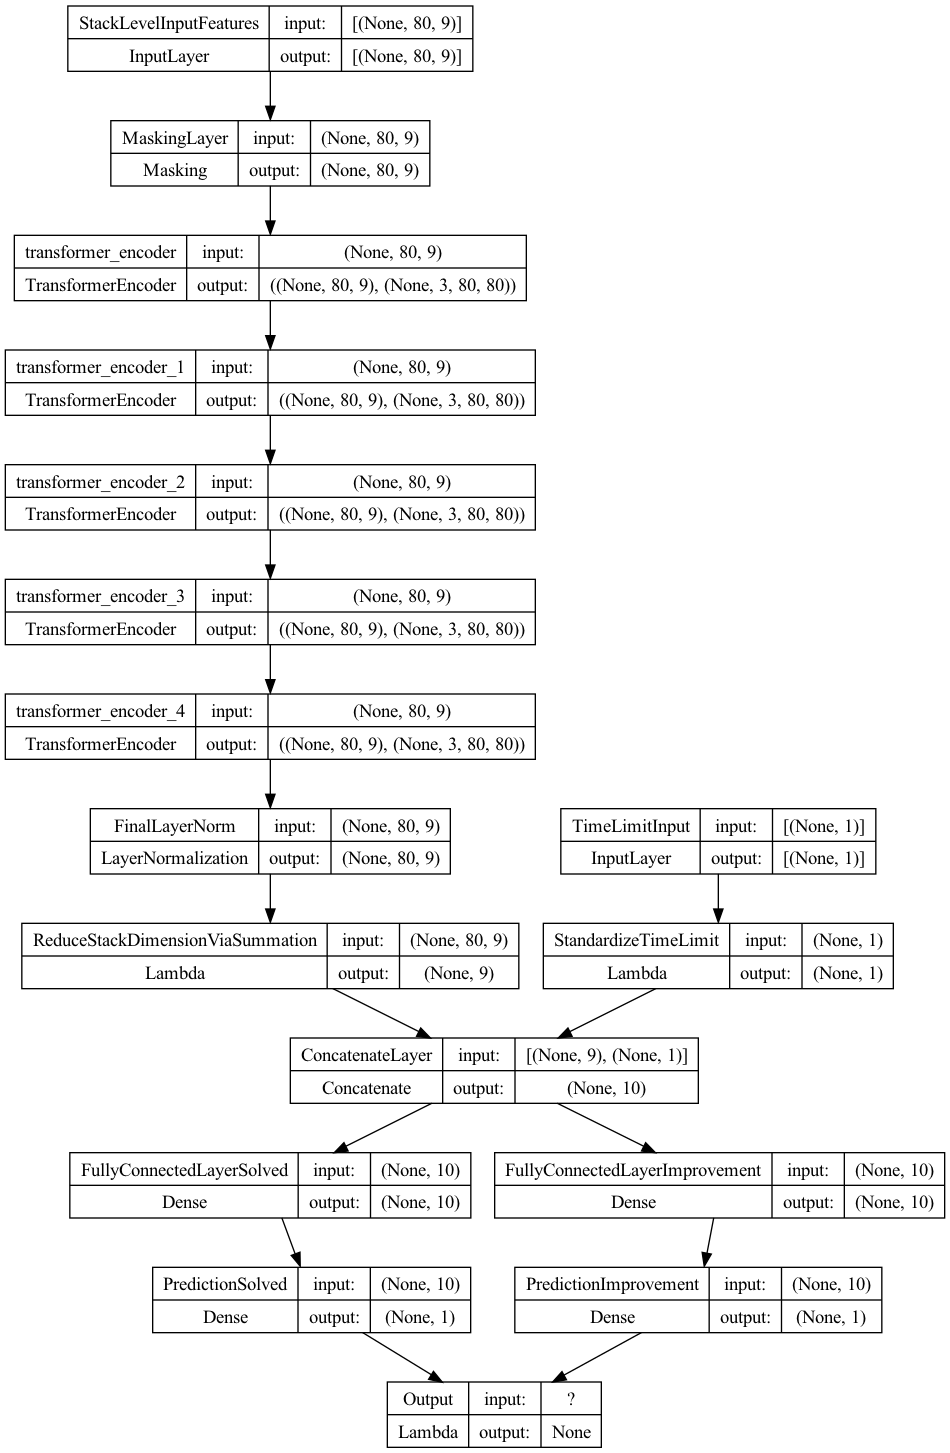

In [18]:
tf.keras.utils.plot_model(
    model,
    #to_file,
    show_shapes=True
)

## Training Process Functions

In [19]:
def geometric_decay(epoch: int, initial_lr:float=10e-3, lr_decay:float=0.9) -> float:
    """
    Exponential decay learning rate schedule
    """
    return initial_lr * lr_decay**epoch

#xx = np.arange(5000)
#yy = geometric_decay(xx, lr_decay=0.9995)
#plt.plot(xx, yy);

In [20]:
def early_stopping(track:pd.DataFrame, patience: int=1, metric: str="Val-Loss", target: str="Improvement") -> bool:
    """
    Early Stopping if no improvement in the metrics after 'patience' epochs.

    Assumes that the metrics is a loss to be minimized.

    TODO:
    -----
    - include option to check for increases in metric rather than just decreases
    """

    assert (type(patience) == int)
    assert (patience > 0)
    
    track = track.loc[(track["Metric"]==metric)&(track["Target"]==target), "Value"]
    
    current_value = track.iloc[-1]
    best_value = track.tail(patience+1).min() # plus1 since, last value is 'current_value', woudl always return True

    # Check if there is an improvement
    # since the current value could be the best
    # we need less or equal
    if current_value <= best_value:
        return False
    else:
        print(f"Early Stopping after no Improvement in {metric} for {target} after {patience} epochs")
        return True

    
    

In [21]:
def print_status_bar(iteration, total, losses, all_metrics=None, training:bool=True):
    tabs = "\t\t\t\t\t\t\t\t\t\t\t\t\t\t"
    metrics = tabs.join([
        f"{TARGET_LABELS[i]:<12}\tLoss: {losses[i].result():.4f}" +
        "\t".join([
            f"{m.name:>10}: {m.result():.2%}"
            if m.name not in ["MAE", "RMSE"]
            else f"{m.name:>10}: {m.result():.4f}"
            for m in metrics
        ])
        for i, metrics in enumerate(all_metrics)
    ])
    
    if training:
        prefix="Training"
    else:
        prefix="Validation"
    
    print(f"\r{prefix}-Iteration: {iteration+1:0>3}/{total:<3}\tLR: {float(optimizer.lr):<1000.9f}" + metrics,
          end="")


In [22]:
@tf.function
def model_pass(model, inputs, targets, training):
    """
    Usual Tensorflow model passing of inputs throught the network.
    If in training mode, the optimizier can apply the gradients
    observed with GradientTape to the model parameters
    """
    
    with tf.GradientTape() as tape:
        
        outputs = model(inputs, training=training)

        # Single output is not a list!
        if type(outputs) != list:
            outputs = [outputs]
            
        losses = [l(t, o) for l,o,t in zip(loss_objects, outputs, targets)]
        
        if training:
            gradients = tape.gradient(losses, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            
        for i, mean_loss in enumerate(mean_losses):
            if len(mean_losses) <= 1:
                mean_loss(losses)
            else:
                mean_loss(losses[i])
        
    return outputs


In [23]:
def run_epoch(model, dataset, target_labels, all_metrics:list[list[tf.keras.metrics]],
              epoch:int, history:pd.DataFrame, training:bool=True,
              shuffle:bool=True):
    """
    Single epoch, running several training steps over a dataset
    """

    for step, X_batch in enumerate(dataset):
        
        X_batch, y_batch = input_output_generation(
            X_batch,
            items=items,
            truck_stops=truck_stops,
            truck_dims=truck_dims,
            target_labels=target_labels,
            shuffle=shuffle,
            pad_size=PAD_SIZE
        )
        
        outputs = model_pass(model, X_batch, y_batch, training=training)
        
        for i, metrics in enumerate(all_metrics):
            for metric in metrics:
                metric(y_batch[i].reshape(-1), outputs[i].numpy().reshape(-1))
    
        print_status_bar(step, len(dataset), mean_losses, all_metrics, training=training)
    
        #### LEARNING RATE UPDATE ####
        if training:
            optimizer.lr = geometric_decay((epoch-1)*len(dataset)+step, initial_lr, lr_decay)
    
    print("\n")

    #### UPDATE METRICS
    for i, metrics in enumerate(all_metrics):
        for metric in metrics:
            data = pd.DataFrame({
                "Epoch": [epoch],
                "Target": [target_labels[i]],
                "Metric": [metric.name if training else f"Val-"+metric.name],
                "Value": [float(metric.result())],
            })
            history = pd.concat([history, data])
            metric.reset_states()

    for i, mean_loss in enumerate(mean_losses):
        data = pd.DataFrame({
            "Epoch": [epoch],
            "Target": [target_labels[i]],
            "Metric": ["Loss" if training else f"Val-"+"Loss"],
            "Value": [float(mean_loss.result())],
        })
        history = pd.concat([history, data])
        mean_loss.reset_states()
            
    return model, history

## Model Training

In [24]:
n_epochs = 15
patience = 1

clms = ["Epoch", "Target", "Metric", "Value"]

track = pd.DataFrame(columns=clms)
    
# get losses and metrics
#loss_objects = [target_loss_objects[target] for target in target_labels]
#mean_losses = [tf.keras.metrics.Mean(name=target) for target in target_labels]
#all_metrics = [all_target_metrics[target] for target in target_labels]
    
    
for epoch in range(1, n_epochs+1):
    
    print(f"Epoch {epoch:0>3}/{ n_epochs:0>3}")
        
    model, track = run_epoch(model, train_dataset, TARGET_LABELS,
                             all_metrics, epoch=epoch, history=track, training=True, shuffle=True)
    model, track = run_epoch(model, val_dataset, TARGET_LABELS,
                             all_metrics, epoch=epoch, history=track, training=False, shuffle=True)
        
    # make an intermediate save of the model
    model_path = os.path.join(cwd, "models", f"MultitaskTraining-MODEL.tf")
    model.save(model_path, overwrite=True, save_format="tf")
        
    # Early Stopping
    if early_stopping(track, patience=patience):
        break
        
        print("-"*120)
    
        
        

Epoch 001/015


2023-12-28 22:15:36.776834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Training-Iteration: 431/431	LR: 0.008069015                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

/var/folders/j4/qmf6qmvd1gv0nctgx3m6jm3r0000gn/T/ipykernel_65789/1590848810.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  history = pd.concat([history, data])


Validation-Iteration: 048/48 	LR: 0.008064981                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/MultitaskTraining-MODEL.tf/assets


Epoch 002/015
Training-Iteration: 431/431	LR: 0.006504391                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/MultitaskTraining-MODEL.tf/assets


INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/MultitaskTraining-MODEL.tf/assets


Epoch 003/015
Training-Iteration: 431/431	LR: 0.005243156                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/MultitaskTraining-MODEL.tf/assets


INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/MultitaskTraining-MODEL.tf/assets


Epoch 004/015
Training-Iteration: 431/431	LR: 0.004226481                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/MultitaskTraining-MODEL.tf/assets


INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/MultitaskTraining-MODEL.tf/assets


Epoch 005/015
Training-Iteration: 431/431	LR: 0.003406945                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/MultitaskTraining-MODEL.tf/assets


INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/MultitaskTraining-MODEL.tf/assets


Epoch 006/015
Training-Iteration: 431/431	LR: 0.002746320                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/MultitaskTraining-MODEL.tf/assets


INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/MultitaskTraining-MODEL.tf/assets


Epoch 007/015
Training-Iteration: 431/431	LR: 0.002213795                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/MultitaskTraining-MODEL.tf/assets


INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/MultitaskTraining-MODEL.tf/assets


Epoch 008/015
Training-Iteration: 431/431	LR: 0.001784528                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/MultitaskTraining-MODEL.tf/assets


INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/MultitaskTraining-MODEL.tf/assets


Early Stopping after no Improvement in Val-Loss for Improvement after 1 epochs


In [25]:
history = track\
    .pivot_table(
        values = ["Value"],
        columns=["Metric"],
        index=["Epoch", "Target"]
    )\
    .reset_index()\
    .set_index("Epoch", drop=True)

clms = history.columns
history.columns = [clm[i>=1] for i, clm in enumerate(clms)]
history

Target       ACC       AUC      Loss       PRC       SNS  \
Epoch                                                                  
1      Improvement  0.679053  0.726027  0.209573  0.670003  0.637529   
1           Solved  0.774012  0.799824  0.122659  0.795846  0.565792   
2      Improvement  0.753073  0.823760  0.174964  0.732709  0.754946   
2           Solved  0.824207  0.866682  0.102574  0.841153  0.677224   
3      Improvement  0.768561  0.847895  0.165056  0.751494  0.765239   
3           Solved  0.836319  0.884007  0.095925  0.852113  0.702263   
4      Improvement  0.779438  0.860506  0.159068  0.765690  0.771070   
4           Solved  0.843910  0.894304  0.091435  0.856833  0.720176   
5      Improvement  0.786128  0.868784  0.154976  0.773728  0.776212   
5           Solved  0.849197  0.901332  0.088171  0.859586  0.733161   
6      Improvement  0.789945  0.874240  0.152309  0.779208  0.777594   
6           Solved  0.852002  0.905371  0.086300  0.861317  0.739688   
7      Improvement  0.793183  0.878340  0.150114  0.783357  0.779722   
7           Solved  0.854480  0.908740  0.084643  0.862970  0.745285   
8      Improvement  0.796295  0.881669  0.148342  0.787357  0.781779   
8           Solved  0.858274  0.912458  0.082937  0.866921  0.752126   

        Val-ACC   Val-AUC  Val-Loss   Val-PRC   Val-SNS  
Epoch                                                    
1      0.740248  0.799749  0.184913  0.750672  0.675300  
1      0.813059  0.856542  0.108523  0.793342  0.708745  
2      0.749888  0.829533  0.171923  0.729566  0.749029  
2      0.832442  0.878235  0.099352  0.832229  0.718259  
3      0.768821  0.854844  0.163598  0.717896  0.842441  
3      0.839876  0.893778  0.093322  0.824615  0.752418  
4      0.776643  0.862187  0.160212  0.741910  0.809548  
4      0.846146  0.898740  0.090413  0.852037  0.736196  
5      0.784343  0.870296  0.154605  0.792329  0.737503  
5      0.851477  0.907363  0.087617  0.905657  0.694239  
6      0.789286  0.872341  0.153639  0.781098  0.770612  
6      0.840019  0.905307  0.090233  0.789145  0.808880  
7      0.790470  0.878439  0.150094  0.786529  0.764698  
7      0.856828  0.912535  0.083505  0.852317  0.768743  
8      0.793350  0.878467  0.150787  0.784369  0.776785  
8      0.857175  0.911937  0.084385  0.874962  0.742539

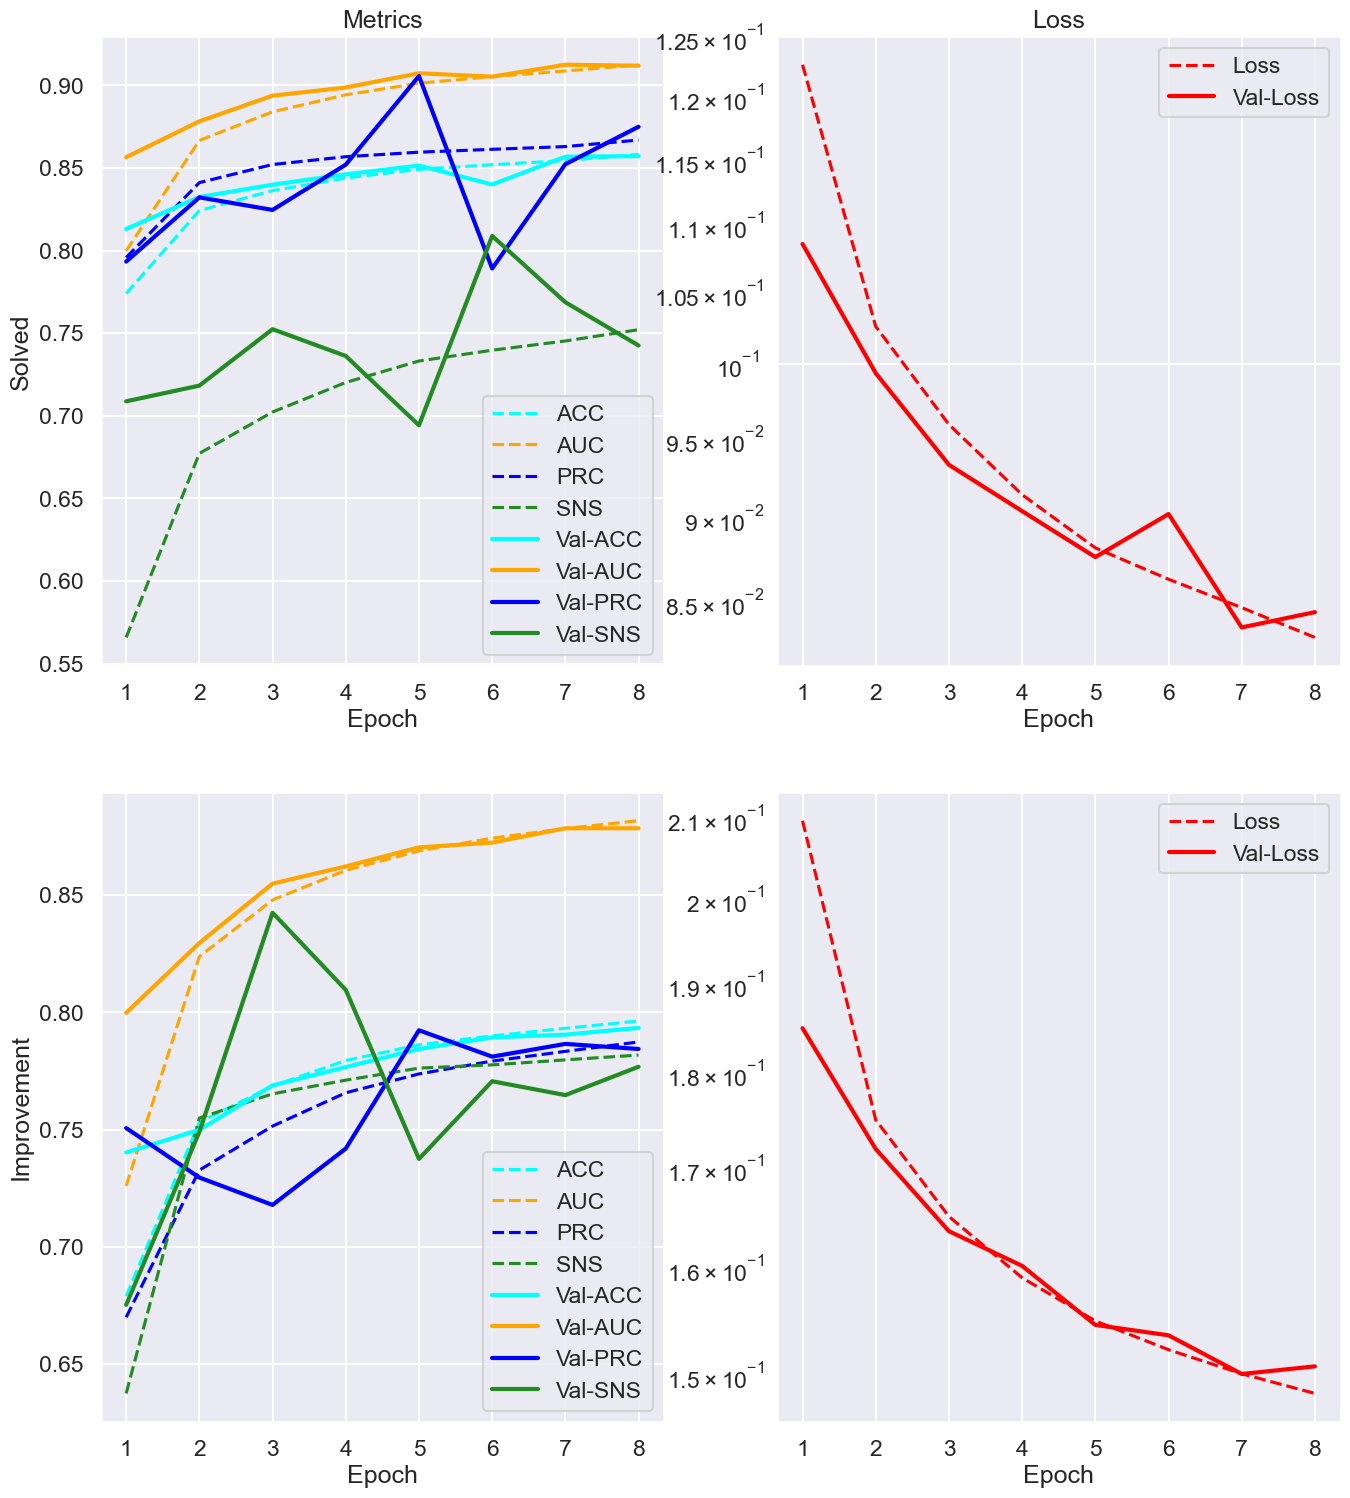

In [26]:
clms = history.columns

fig, ax = plt.subplots(len(TARGET_LABELS), 2, figsize=(16, 9*len(TARGET_LABELS)))

colors = ["cyan", "orange", "blue", "forestgreen", "red", "purple"]

for i, target in enumerate(TARGET_LABELS):
    history.loc[(history.Target == target), (~clms.str.contains("Val-"))&(~clms.str.contains("Loss"))]\
        .plot(ax=ax[i, 0],ls = "--", color = colors, label = "Training")
    history.loc[(history.Target == target), (clms.str.contains("Val-"))&(~clms.str.contains("Loss"))]\
        .plot(ax=ax[i, 0], lw = 3, color = colors, label = "Validation")
    ax[i, 0].set(ylabel = target)

    # Plot the loss
    history.loc[(history.Target == target), (~clms.str.contains("Val-"))&(clms.str.contains("Loss"))]\
        .plot(ax=ax[i, 1], ls = "--", color = "red", label = "Training") 
    history.loc[(history.Target == target), (clms.str.contains("Val-"))&(clms.str.contains("Loss"))]\
        .plot(ax=ax[i, 1], lw = 3, color = "red", label = "Validation")
    ax[i, 1].set(yscale = "log")

ax[0, 0].set(title="Metrics")
ax[0, 1].set(title="Loss");


Tradeoff between Sensitivity and Precision can be seen very good here.
Most likely explanation:
- the bias of the final layer before the sigmoid has changed drastically.
- if the bias increases, predicted probabilities increase. This means more found solved cases and higher Sensitivity
- if the bias decreases, predicted probabilities decrease. This means less found solved cases, only the more certain cases. Higher Precision

### Visualize Attention Scores:

In [28]:
from utils.DNN.utils import get_attention_scores

#attention = get_attention_scores(model, model_inputs=cx, layer_name=f"transformer_encoder_{n_blocks-1}")
attention = get_attention_scores(model, model_inputs=cx, layer_name=f"transformer_encoder_4")
attention.shape
#cx[0][24].round(2)[:40]

(1024, 3, 80, 80)

In [30]:
get_attention_scores(model, model_inputs=cx, layer_name=f"transformer_encoder_4")

array([[[[0.01363132, 0.01305143, 0.0115141 , 0.0156551 , 0.01365818, 0.01462525, 0.0130193 , 0.01854019, 0.0005117 , 0.01433348, 0.01420322, 0.01741118, 0.01420322, 0.01681201, 0.01741118, 0.02034118, 0.01779408, 0.0268736 , 0.00449641, 0.00489733, 0.00111518, 0.01213392, 0.01213392, 0.01213392, 0.01213392, 0.01213392, 0.01213392, 0.01213392, 0.01213392, 0.01213392, ..., 0.01213392, 0.01213392, 0.01213392, 0.01213392, 0.01213392, 0.01213392, 0.01213392, 0.01213392, 0.01213392, 0.01213392, 0.01213392, 0.01213392, 0.01213392, 0.01213392, 0.01213392, 0.01213392, 0.01213392, 0.01213392, 0.01213392, 0.01213392, 0.01213392, 0.01213392, 0.01213392, 0.01213392, 0.01213392, 0.01213392, 0.01213392, 0.01213392, 0.01213392, 0.01213392],
         [0.01661022, 0.01585332, 0.01386129, 0.01929532, 0.01664538, 0.01803102, 0.01590758, 0.02345745, 0.00061391, 0.01647   , 0.01632482, 0.01989603, 0.01632482, 0.01922947, 0.01989603, 0.02315568, 0.02041676, 0.03083874, 0.00519207, 0.00562516, 0.00198742, 0.

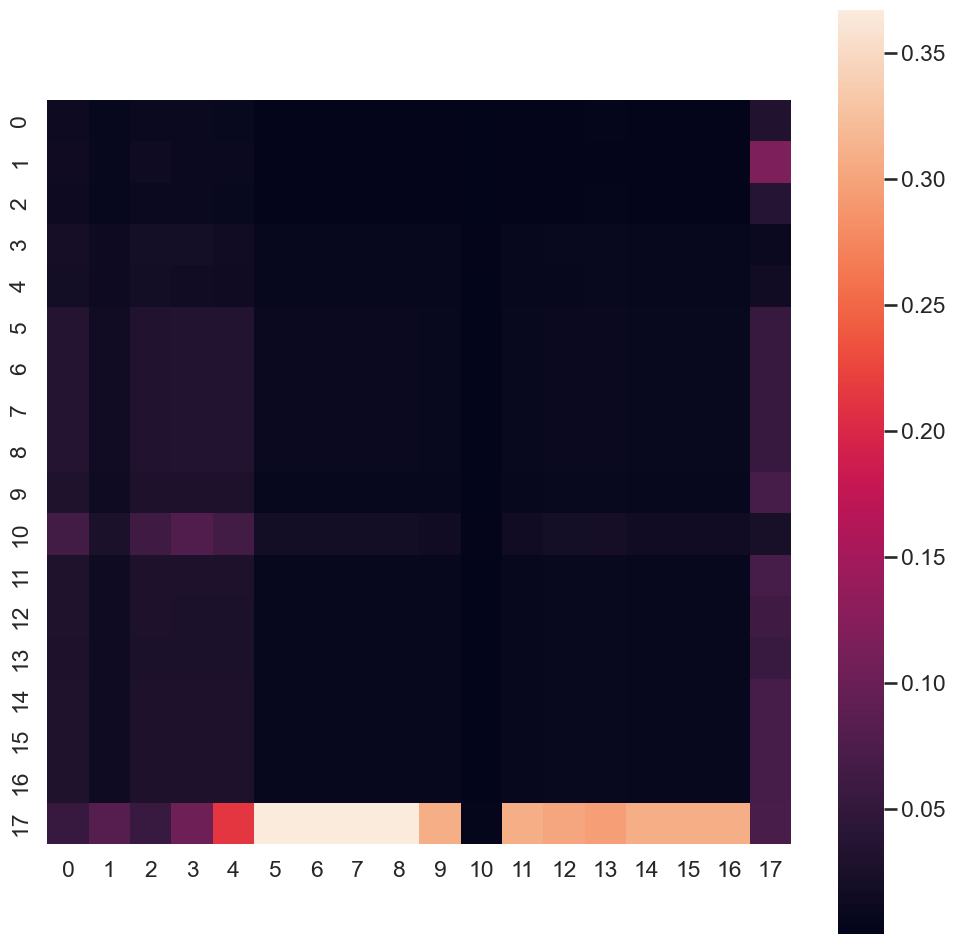

In [32]:
instance, head = 24, 1 # 18: 36 # 24 is a very simple but good example
head = min(head, num_heads-1)

attention_matrix = attention[instance, head, :, :]

# truncate:
n_inputs = np.argmax(np.all(cx[0][instance].round(2) == 0, axis=1))
attention_matrix = attention_matrix[:n_inputs, :n_inputs]

plt.figure(figsize=(12, 12))
sns.heatmap(attention_matrix.T,
            square=True,
            #vmin=0, vmax=1
           );

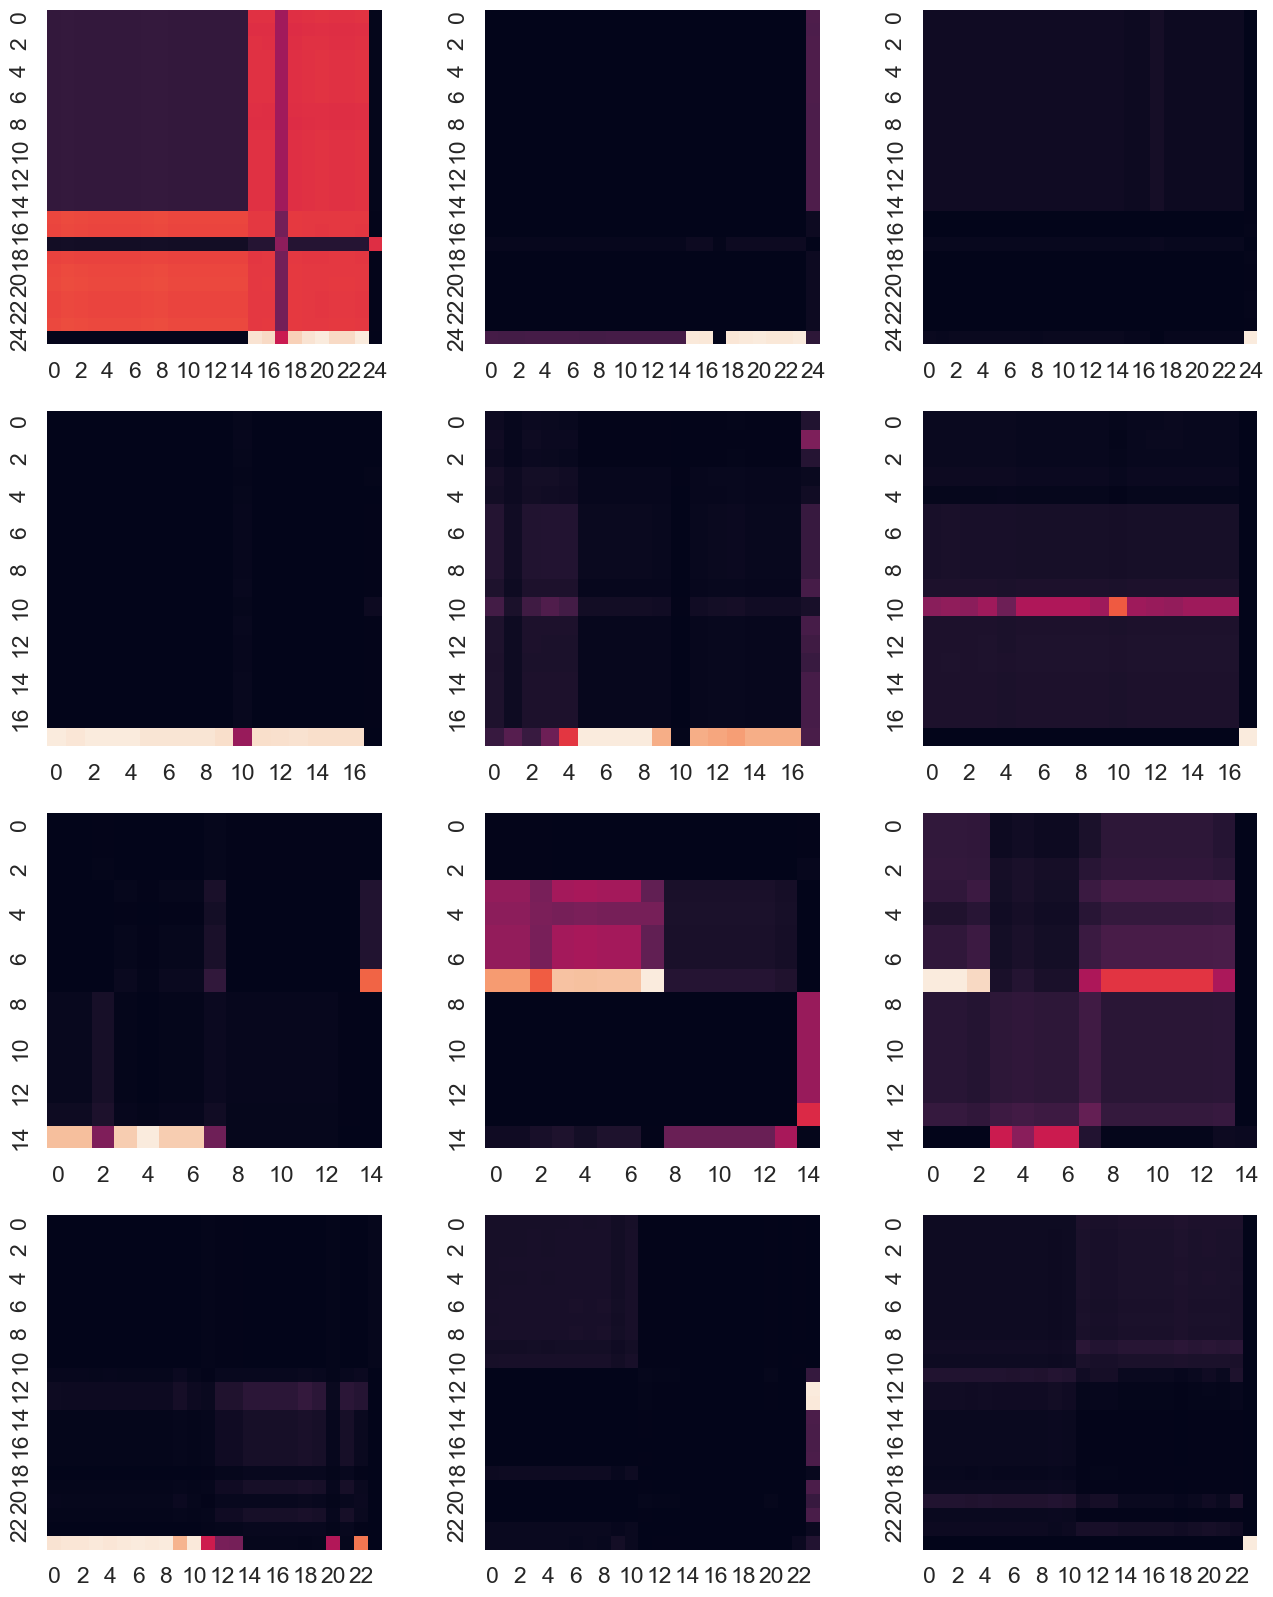

In [34]:
instances = [28, 24, 25, 26]

heads = list(range(num_heads))

fig, ax = plt.subplots(len(instances), num_heads, figsize=(16, len(instances)*5))

for i, instance in enumerate(instances):
    for h, head in enumerate(heads):

        # Truncate
        attention_matrix = attention[instance, head, :, :]
        n_inputs = np.argmax(np.all(cx[0][instance].round(2) == 0, axis=1))
        attention_matrix = attention_matrix[:n_inputs, :n_inputs]
        
        sns.heatmap(
            attention_matrix.T,
            square=True,
            cbar=False,
            #vmin=0, vmax=0.1,
            ax=ax[i, h]
        );

# Load the model to see if it works

In [35]:
model_path = os.path.join(cwd, "models", f"MultitaskTraining-MODEL.tf")

#loaded_model = tf.keras.models.load_model(model_path)

In [36]:
y_pred = model(cx);

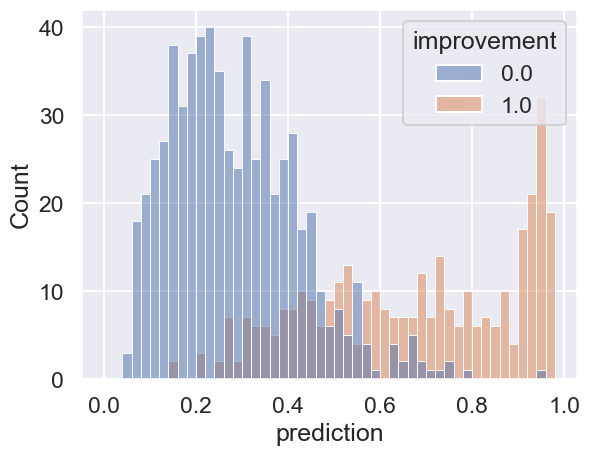

In [37]:
pred_df = data=pd.DataFrame([y_pred[0].numpy(), cy[0]]).T
pred_df.columns = ["prediction", "improvement"]

sns.histplot(
    data=pred_df,
    x="prediction",
    hue="improvement",
    bins=np.arange(0, 1, 0.02)
);

In [38]:
val_dataset = keras.preprocessing.text_dataset_from_directory(
    directory = val_samples,
    labels = None,
    batch_size = BATCH_SIZE,
    max_length = None,
    shuffle = True,
    seed = SEED,
)

Found 116586 files belonging to 1 classes.


In [39]:
_ = run_epoch(model, val_dataset, TARGET_LABELS, all_metrics, epoch=epoch, history=track, training=False, shuffle=True)

Validation-Iteration: 114/114	LR: 0.001783636                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

(<keras.src.engine.functional.Functional at 0x2b3e00290>,
    Epoch       Target    Metric     Value
 0      1       Solved       PRC  0.795846
 0      1       Solved       SNS  0.565792
 0      1       Solved       AUC  0.799824
 0      1       Solved       ACC  0.774012
 0      1  Improvement       PRC  0.670003
 ..   ...          ...       ...       ...
 0      8  Improvement   Val-SNS  0.782553
 0      8  Improvement   Val-AUC  0.894567
 0      8  Improvement   Val-ACC  0.815896
 0      8       Solved  Val-Loss  0.076930
 0      8  Improvement  Val-Loss  0.140862
 
 [170 rows x 4 columns])

# Compare the relationship between solved and inproved instances

In [41]:
for X_val_raw in val_dataset:
    X_val, y_val = input_output_generation(
            X_val_raw,
            items=items,
            truck_stops=truck_stops,
            truck_dims=truck_dims,
            target_labels=TARGET_LABELS,
            shuffle=False,
            pad_size=PAD_SIZE
        )
    break

X_val_raw = X_val_raw.numpy().astype(str)

In [42]:
print(X_val_raw[0])

dataset: X
instance: DO6
+-----------+
2D Packing MIP with Time Limit 30 [s] in Truck P200043203
Stack 0 with items: ['0090019100_14062023000192', '0090019100_14062023000192', '0090019100_14062023000192']
Stack 1 with items: ['0090019100_14062023006570', '0090019100_14062023006570', '0090019100_14062023006570']
Stack 2 with items: ['0090019100_14062023000192', '0090019100_14062023006570', '0090019100_14062023006570']
Stack 3 with items: ['0090019100_14062023000192', '0090019100_14062023006570', '0090019100_14062023006570']
Stack 4 with items: ['0090019100_14062023006570', '0090019100_14062023006570', '0090019100_14062023006570']
Stack 5 with items: ['0090019100_14062023006570', '0090019100_14062023006570', '0090019100_14062023006570']
Stack 6 with items: ['0090019100_14062023000192', '0090019100_14062023006570', '0090019100_14062023006570']
Stack 7 with items: ['0090019100_14062023006570', '0090019100_14062023000192', '0090019100_14062023000192']
Stack 8 with items: ['0090019100_140620

In [49]:
X_val[0][0,:25]

array([[ 1.2       ,  1.        ,  0.880544  ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.44000006],
       [ 1.2       ,  1.        ,  0.880544  ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.44000006],
       [ 1.2       ,  1.        ,  1.465408  ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.44000006],
       [ 1.2       ,  1.        ,  0.880544  ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.44000006],
       [ 1.6       ,  1.2       ,  1.71984   ,  0.        ,  0.        ,  1.        ,  0.        ,  0.84000003,  0.03999996],
       [ 2.4       ,  1.2       ,  1.454952  ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.03999996],
       [ 2.4       ,  1.2       ,  1.454952  ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.03999996],
       [ 2.4       ,  1.2       ,  1.454952  ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.039

In [44]:
y_pred_solved, y_pred_improvement = model(X_val)
y_pred_solved, y_pred_improvement = y_pred_solved.numpy(), y_pred_improvement.numpy()

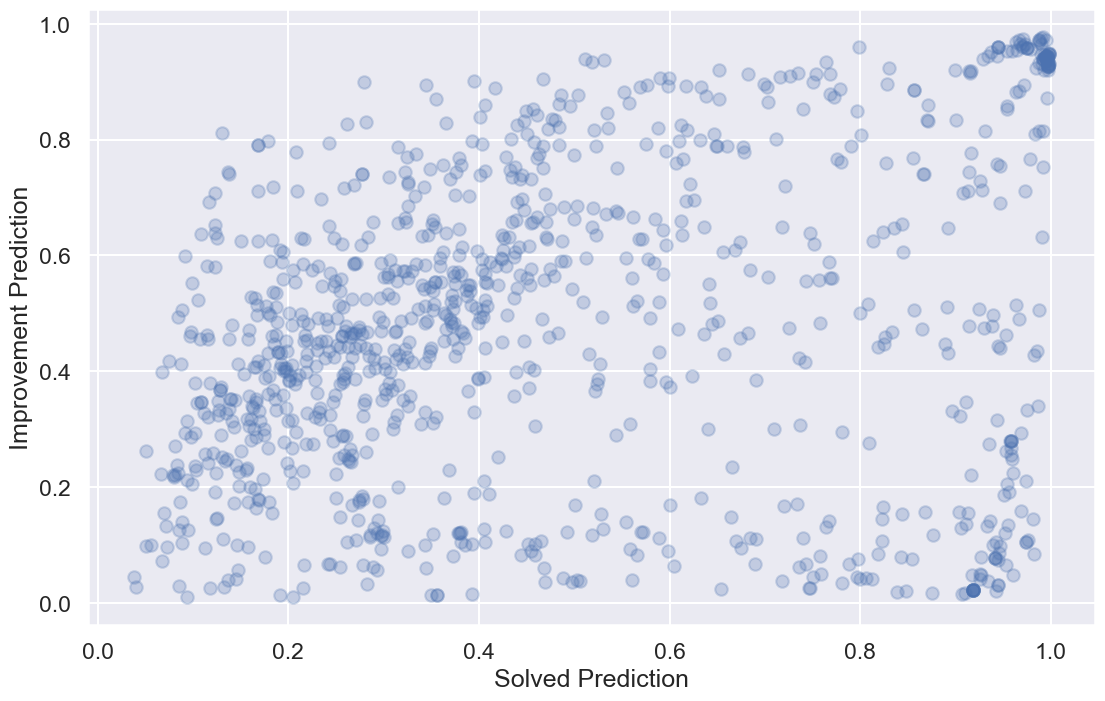

In [45]:
plt.figure(figsize=(13, 8))
plt.scatter(y_pred_solved, y_pred_improvement, alpha = 0.25);
plt.xlabel("Solved Prediction")
plt.ylabel("Improvement Prediction");